In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os
from crflux.models import H3a_polygonato
import crflux.models as crf
from MCEq.core import MCEqRun

In [2]:
data_dir = 'data/atmospheric_flux_deflection/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/atmospheric_flux_deflection/'
os.system('mkdir -p {}'.format(plot_dir))

save_plot = True

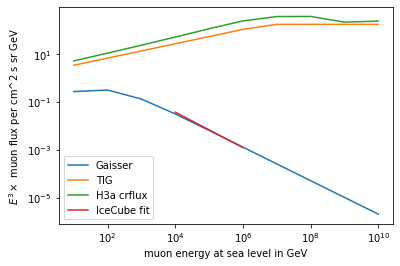

In [3]:
# Gaisser 1990

def muon_flux_gaisser(E_sea, E_top=None, theta=0):
    '''
        Parameters
        ----------
        E_sea: muon energy at sea level
        E_top: muon energy at the top of the atmosphere
        theta: muon zenith angle
        A_G: scale factory
    '''
    A_G = 0.14
    gamma = 2.7
    E_top = E_sea # at high energies
    epsilon_pi = 115/1.1 # GeV
    epsilon_kaon = 810/1.1 # GeV
    B_G = 0.054
    return A_G * E_sea**(-gamma) * ((1/(1 + E_top * np.cos(theta)/epsilon_pi)) + (B_G / (1 + E_top * np.cos(theta)/epsilon_kaon)))


# TIG model
def TIG(energies):
    E_list = []
    for E in energies:
        if E < 5e6:
            E_list.append(1.7e4 * E**(-2.7))
        elif E >= 5e6:
            E_list.append(174e4 * E**(-3))
    return np.array(E_list)

# https://arxiv.org/pdf/1907.00640.pdf
def muon_flux_icecube(E_mu):
    '''
        Parameters
        ----------
        E_mu: muon energy in GeV
    '''
    gamma = 3.74
    return 9e-17 * (E_mu / 50e3)**(-gamma)

    
energies = np.logspace(1, 10, 10)
plt.plot(energies, muon_flux_gaisser(energies) * energies**3, label='Gaisser')
plt.plot(energies, TIG(energies) * 1e-4 * energies**3, label='TIG')
plt.plot(energies, H3a_polygonato().total_flux(energies) * 1e-4 * energies**3, label='H3a crflux')
energies = np.logspace(4, 6, 10)
plt.plot(energies, muon_flux_icecube(energies) * energies**3, label='IceCube fit')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy at sea level in GeV')
plt.ylabel(r'$E^3 \times$ muon flux per cm^2 s sr GeV')
plt.legend()

In [55]:
mceq_90 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=90.)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [56]:
# h_grid = np.linspace(50 * 1e3 * 1e2, 0) # altitudes from 50km to 0cm
# X_grid = mceq.density_model.h2X(h_grid)
# mceq.solve(int_grid=X_grid)
mceq_90.solve()

In [6]:
mceq_0 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=0.)
mceq_0.solve()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [53]:
mceq_60 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=60.)
mceq_60.solve()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [42]:
e_bin_mids = np.array([])
for i in range(len(mceq.e_bins))[:-1]:
    e_bin_mids = np.append(e_bin_mids, mceq.e_bins[i] + (mceq.e_bins[i+1] - mceq.e_bins[i])/2)

Text(0.5, 1.0, 'mu+ and mu-')

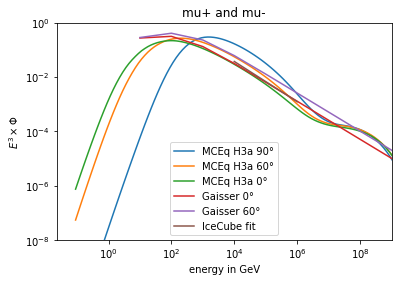

In [57]:
# MCEq
plt.plot(e_bin_mids, mceq_90.get_solution('mu-', mag=3) + mceq_90.get_solution('mu+', mag=3), label='MCEq H3a 90°')
plt.plot(e_bin_mids, mceq_60.get_solution('mu-', mag=3) + mceq_60.get_solution('mu+', mag=3), label='MCEq H3a 60°')
plt.plot(e_bin_mids, mceq_0.get_solution('mu-', mag=3) + mceq_0.get_solution('mu+', mag=3), label='MCEq H3a 0°')
# plt.plot(e_bin_mids, (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * e_bin_mids**3, label='MCEq H3a 0°')

# gaisser
energies = np.logspace(1, 10, 10)
plt.plot(energies, muon_flux_gaisser(energies, theta=0.) * energies**3, label='Gaisser 0°')
plt.plot(energies, muon_flux_gaisser(energies, theta=np.deg2rad(60.)) * energies**3, label='Gaisser 60°')
# icecube fit
energies = np.logspace(4, 6, 10)
plt.plot(energies, muon_flux_icecube(energies) * energies**3, label='IceCube fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel(r'$E^3 \times \Phi$ ')
plt.xlim(None, 1e9)
plt.ylim(1e-8, 1)
plt.legend()
plt.title('mu+ and mu-')

4.1590234864581985

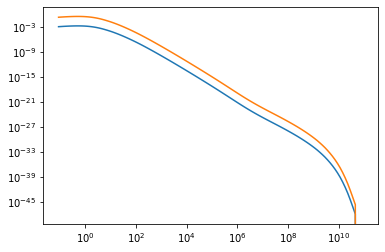

In [72]:
from sklearn import preprocessing
plt.plot(e_bin_mids, mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+'), label='MCEq')
plt.plot(e_bin_mids, preprocessing.normalize([mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')])[0], label='normalized')
plt.yscale('log')
plt.xscale('log')
np.sum(preprocessing.normalize([mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')])[0])

In [ ]:
momentum = 7.3e3 # GeV/c , 
m = 105.7 # MeV
E = np.round(np.sqrt(momentum**2 + m**2))
print('energy E = {} MeV'.format(E) )


E_i = E # momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = 31125 # total measured events in akimenko
    
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-3 # 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 33

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 1.44 # in cm

In [ ]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Copper(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


# collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
# '''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
# '''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

In [ ]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)